In [9]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('C://Users//manit//Downloads//data-augmented.csv')

# Combine all text columns into a single text column
text_columns = df.columns[1:]  # Assuming text columns start from the second column
df['combined_text'] = df[text_columns].apply(lambda row: ' '.join(map(str, row)), axis=1)

# Preprocess the text data for each language
def preprocess_text(text, language='english'):
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Apply language-specific preprocessing for each text column
for lang_column in text_columns:
    lang = lang_column.split('_')[0]  # Extract language code from column name
    df[f'{lang_column}_processed'] = df[lang_column].apply(lambda text: preprocess_text(text, language=lang))

# Label Encoding
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['labels'])

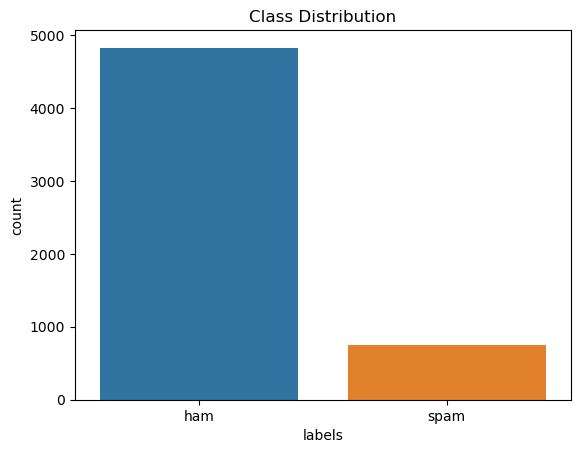

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
sns.countplot(x='labels', data=df)
plt.title('Class Distribution')
plt.show()


In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

spam_messages = df[df['labels'] == 'spam']['text']
ham_messages = df[df['labels'] == 'ham']['text']

def generate_wordcloud(messages, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(messages))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


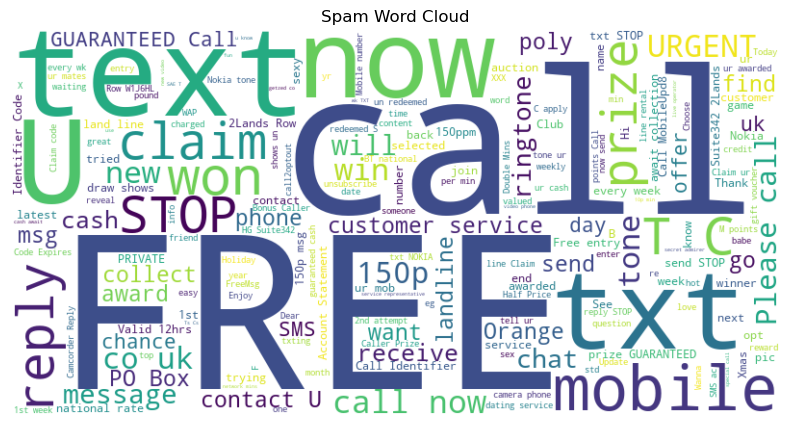

In [15]:
# Generate word cloud for spam messages
generate_wordcloud(spam_messages, 'Spam Word Cloud')

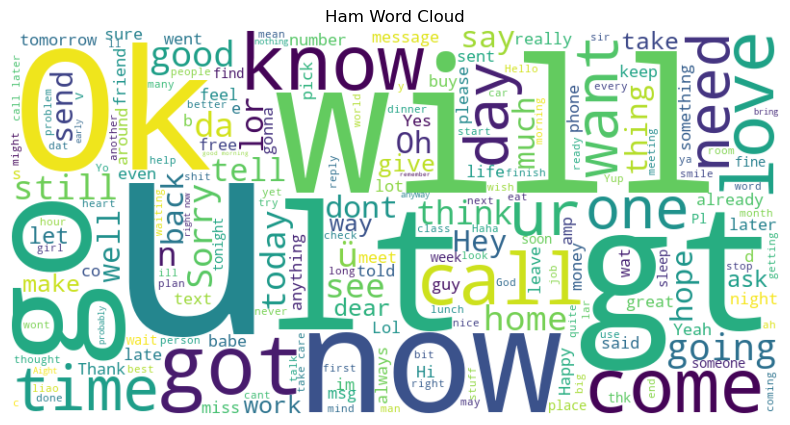

In [16]:
# Generate word cloud for ham messages
generate_wordcloud(ham_messages, 'Ham Word Cloud')

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import pipeline

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def train_models(df):
    # Split the dataset into training and testing sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df['text'].astype(str), df['label_encoded'], test_size=0.4, random_state=42
    )

    # Train Multinomial Naive Bayes Classifier
    nb_classifier = make_pipeline(CountVectorizer(), MultinomialNB())
    nb_classifier.fit(train_texts, train_labels)

    # Evaluate Naive Bayes model
    nb_predictions = nb_classifier.predict(test_texts)
    nb_conf_matrix = confusion_matrix(test_labels, nb_predictions)
    nb_classification_report = classification_report(test_labels, nb_predictions)
    nb_accuracy = accuracy_score(test_labels, nb_predictions)
    
    print("Multinomial Naive Bayes:")
    print("Confusion Matrix:\n", nb_conf_matrix)
    print("\nClassification Report:\n", nb_classification_report)
    print("\nAccuracy:", nb_accuracy)
    print("\n--------------------------------------------------------\n")

    # Train Neural Network Model using Keras
    max_words = 1000
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts)

    train_sequences = tokenizer.texts_to_sequences(train_texts)
    test_sequences = tokenizer.texts_to_sequences(test_texts)

    max_sequence_length = max(len(seq) for seq in train_sequences)
    train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
    test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)

    embedding_dim = 16
    nn_model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length),
        GlobalAveragePooling1D(),
        Dense(1, activation='sigmoid')
    ])
    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Print intermediate metrics during training
    history_nn = nn_model.fit(train_data, train_labels, epochs=5, validation_split=0.2)

    # Evaluate Neural Network model
    nn_predictions = nn_model.predict(test_data)
    nn_predictions = (nn_predictions > 0.5).astype(int)  # Assuming it's a binary classification task
    nn_conf_matrix = confusion_matrix(test_labels, nn_predictions)
    nn_classification_report = classification_report(test_labels, nn_predictions)
    nn_accuracy = accuracy_score(test_labels, nn_predictions)


    print("Neural Network:")
    print("Confusion Matrix:\n", nn_conf_matrix)
    print("\nClassification Report:\n", nn_classification_report)
    print("\nAccuracy:", nn_accuracy)
    print("\n--------------------------------------------------------\n")

    # Fine-tune BERT
    tokenizer_bert = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')

    train_encodings = tokenizer_bert(train_texts.tolist(), truncation=True, padding=True, max_length=64, return_tensors='tf')
    train_encodings_dict = {key: train_encodings[key].numpy() for key in train_encodings}

    test_encodings = tokenizer_bert(test_texts.tolist(), truncation=True, padding=True, max_length=64, return_tensors='tf')
    test_encodings_dict = {key: test_encodings[key].numpy() for key in test_encodings}

    model_bert.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Print intermediate metrics during training
    history_bert = model_bert.fit(train_encodings_dict, train_labels, epochs=3, batch_size=32, validation_split=0.2)

    # Evaluate BERT model
    bert_predictions = model_bert.predict(test_encodings_dict)['logits'].argmax(axis=1)
    bert_conf_matrix = confusion_matrix(test_labels, bert_predictions)
    bert_classification_report = classification_report(test_labels, bert_predictions)
    bert_accuracy = accuracy_score(test_labels, bert_predictions)

    print("BERT:")
    print("Confusion Matrix:\n", bert_conf_matrix)
    print("\nClassification Report:\n", bert_classification_report)
    print("\nAccuracy:", bert_accuracy)
    print("\n--------------------------------------------------------\n")

    return nb_classifier, nn_model, model_bert, tokenizer_bert



In [18]:
nb_classifier, nn_model, bert_model, tokenizer = train_models(df)


Multinomial Naive Bayes:
Confusion Matrix:
 [[1929    9]
 [  17  274]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1938
           1       0.97      0.94      0.95       291

    accuracy                           0.99      2229
   macro avg       0.98      0.97      0.97      2229
weighted avg       0.99      0.99      0.99      2229


Accuracy: 0.9883355764917003

--------------------------------------------------------

Epoch 1/5
84/84 [==============================] - 0s 2ms/step - loss: 0.5845 - accuracy: 0.8661 - val_loss: 0.5100 - val_accuracy: 0.8535
Epoch 2/5
84/84 [==============================] - 0s 2ms/step - loss: 0.4464 - accuracy: 0.8661 - val_loss: 0.4212 - val_accuracy: 0.8535
Epoch 3/5
84/84 [==============================] - 0s 1ms/step - loss: 0.3884 - accuracy: 0.8661 - val_loss: 0.3978 - val_accuracy: 0.8535
Epoch 4/5
84/84 [==============================] - 0s 2ms/step - loss: 

C:\ProgramData\anaconda3\envs\dsci6004\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\dsci6004\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\dsci6004\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
84/84 [==============================] - 641s 8s/step - loss: 2.4180 - accuracy: 0.8414 - val_loss: 2.3611 - val_accuracy: 0.8535
Epoch 2/3
84/84 [==============================] - 652s 8s/step - loss: 2.2664 - accuracy: 0.8594 - val_loss: 2.3611 - val_accuracy: 0.8535
Epoch 3/3
70/70 [==============================] - 128s 2s/step
BERT:
Confusion Matrix:
 [[1938    0]
 [ 291    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      1938
           1       0.00      0.00      0.00       291

    accuracy                           0.87      2229
   macro avg       0.43      0.50      0.47      2229
weighted avg       0.76      0.87      0.81      2229


Accuracy: 0.8694481830417228

--------------------------------------------------------



C:\ProgramData\anaconda3\envs\dsci6004\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\dsci6004\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\dsci6004\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
def predict_spam_or_ham(text, nb_classifier, nn_model, bert_model, bert_tokenizer):
    """
    Predicts whether a given text is spam or ham using Naive Bayes, Neural Network, and BERT models.

    Args:
        text: The text to classify as spam or ham.
        nb_classifier: The trained Naive Bayes classifier.
        nn_model: The trained neural network model.
        bert_model: The trained BERT model.
        bert_tokenizer: The BERT tokenizer.

    Returns:
        A dictionary containing the predictions from each model.
    """
    
    # Naive Bayes prediction
    nb_prediction = nb_classifier.predict([text])[0]

    # Neural Network prediction
    nn_sequence = bert_tokenizer.encode_plus(text, return_tensors='tf')['input_ids']
    nn_prediction = nn_model.predict(nn_sequence)[0][0]

    # BERT prediction
    bert_encoding = bert_tokenizer.encode_plus(text, return_tensors='tf')
    input_ids = bert_encoding['input_ids']
    attention_mask = bert_encoding['attention_mask']
    bert_prediction = bert_model.predict({'input_ids': input_ids, 'attention_mask': attention_mask})[0]

    return {
        'Naive Bayes Prediction': nb_prediction,
        'Neural Network Prediction': nn_prediction,
        'BERT Prediction': bert_prediction.argmax()
    }


In [25]:
# 1 --> Spam
# 0 --> Ham / not spam

text_to_predict = "Nej, jag tror inte att han gÃ¥r till usf, han bor hÃ¤r om Ã¤n"
predictions = predict_spam_or_ham_(text_to_predict, nb_classifier, nn_model, bert_model, tokenizer)
print(predictions)

{'Naive Bayes Prediction': 0, 'Neural Network Prediction': 0, 'BERT Prediction': 0}


In [23]:
text_to_predict = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
predictions = predict_spam_or_ham_(text_to_predict, nb_classifier, nn_model, bert_model, tokenizer)
print(predictions)

{'Naive Bayes Prediction': 1, 'Neural Network Prediction': 1, 'BERT Prediction': 1}


In [24]:
text_to_predict = "T-Mobile customer you may now claim your FREE CAMERA PHONE upgrade & a pay & go sim card for your loyalty. Call on 0845 021 3680.Offer ends 28thFeb.T&C's apply"
predictions = predict_spam_or_ham_(text_to_predict, nb_classifier, nn_model, bert_model, tokenizer)
print(predictions)

{'Naive Bayes Prediction': 1, 'Neural Network Prediction': 1, 'BERT Prediction': 1}
